# Deep Learning Medical Image Analysis Example
A simple convolutional neural network model trained using a PneumoniaMNIST image dataset.

The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images.

## Python Imports
This section will load the necessary python packages to the instance.

In [1]:
# Built-in Imports
import random

In [2]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Keras Imports
from tensorflow.keras import layers,models,preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader
This section will download the selected [MedMNIST](https://medmnist.github.io/) dataset as a NumPy array object to your Google Colab instance. 

In [4]:
# MedMNIST Pneumonia Binary Classification Dataset
DATA_NAME = "PneumoniaMNIST";

In [5]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2022-04-08 22:56:56--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22843 (22K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  22.31K  --.-KB/s    in 0s      

2022-04-08 22:56:56 (63.2 MB/s) - ‘info.py’ saved [22843/22843]



In [6]:
# Info about Dataset
data

{'MD5': '28209eda62fecd6e6a2d98b1501bb15f',
 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.',
 'label': {'0': 'normal', '1': 'pneumonia'},
 'license': 'CC BY 4.0',
 'n_channels': 1,
 'n_samples': {'test': 624, 'train': 4708, 'val': 524},
 'python_class': 'PneumoniaMNIST',
 'task': 'binary-class',
 'url': 'https://zenodo.org/record/5208230/files/pneumoniamnist.npz?download=1'}

In [7]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz", 
                     origin=data["url"], 
                     md5_hash=data["MD5"])

4186112/4170669 [==============================] - 1s 0us/step


In [8]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]

## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [9]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]), 
                            np.append(val_counts, [sum(val_counts)]), 
                            np.append(test_counts, [sum(test_counts)]))), 
                   index=labels, columns=["Train", "Val", "Test"]))

           Train  Val  Test
normal      1214  135   234
pneumonia   3494  389   390
total       4708  524   624


1731: pneumonia


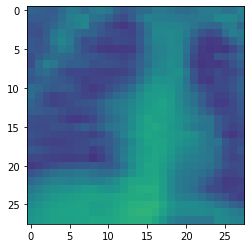

In [10]:
# Displays a random Grayscale image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))],vmin=0, vmax=255)

In [11]:
# Adding depth dimension for Grayscale images for rank 4
train_x = train_x[...,np.newaxis]
val_x = val_x[...,np.newaxis]

## Data Processing
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed.

In [12]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True, 
                                    vertical_flip=True)

In [13]:
# Fit the Data to DataGenerator
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition
In this section we will define the neural network arcitecture.

In [14]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool_2)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="sigmoid")(flatten)

# Initilises the defined model and prints summary of the model.
model = Model(inputs=input, outputs=output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0     

## Model Training
This is where we define the training options and then train the model.


In [15]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

In [38]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])

In [21]:
train_x.shape,train_y.shape

((4708, 28, 28, 1), (4708, 1))

In [39]:
# We use the data generator to pass the training and validation data to the model to train it.
history = model.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE), 
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/20
73/73 [==============================] - 4s 51ms/step - loss: 0.5634 - accuracy: 0.7421 - val_loss: 0.5657 - val_accuracy: 0.7424
Epoch 2/20
73/73 [==============================] - 4s 49ms/step - loss: 0.5571 - accuracy: 0.7421 - val_loss: 0.5587 - val_accuracy: 0.7424
Epoch 3/20
73/73 [==============================] - 4s 50ms/step - loss: 0.5510 - accuracy: 0.7421 - val_loss: 0.5516 - val_accuracy: 0.7424
Epoch 4/20
73/73 [==============================] - 4s 49ms/step - loss: 0.5456 - accuracy: 0.7421 - val_loss: 0.5469 - val_accuracy: 0.7424
Epoch 5/20
73/73 [==============================] - 4s 49ms/step - loss: 0.5393 - accuracy: 0.7421 - val_loss: 0.5403 - val_accuracy: 0.7424
Epoch 6/20
73/73 [==============================] - 4s 50ms/step - loss: 0.5325 - accuracy: 0.7421 - val_loss: 0.5376 - val_accuracy: 0.7424
Epoch 7/20
73/73 [==============================] - 4s 50ms/step - loss: 0.5281 - accuracy: 0.7421 - val_loss: 0.5323 - val_accuracy: 0.7424
Epoch 8/20
73

In [25]:
# Evaluating model on test data
test_y = to_categorical(test_y)


In [40]:
model.evaluate(test_x, test_y)

20/20 [==============================] - 0s 9ms/step - loss: 95.6750 - accuracy: 0.6250


[95.67496490478516, 0.625]

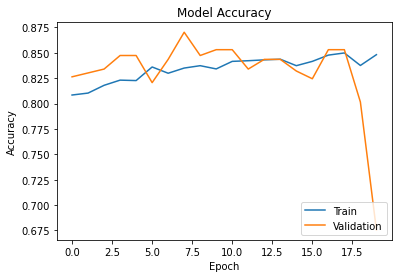

In [93]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

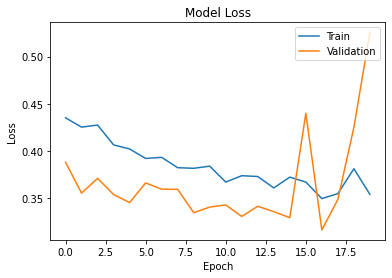

In [94]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Plot Learning Curves
This is where we visualise the training of the model.

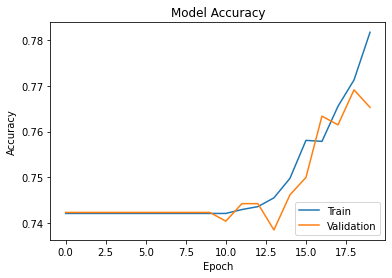

In [41]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

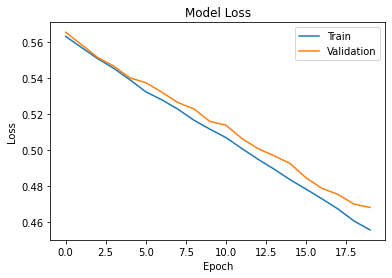

In [42]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Model Definition Q2
In this section we will define the neural network arcitecture.

A network with dense layers but no convolutional layers, designed to have a total number of
parameters comparable to the convnet in 1.

In [44]:
# Q2 Assn, Only Dense Layers

# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Dense Layers
flatten = layers.Flatten()(input)
dense1 = layers.Dense(16, activation='relu')(flatten)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="sigmoid")(dense1)

# Initilises the defined model and prints summary of the model.
denseModel = Model(inputs=input, outputs=output, name="Model")
denseModel.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 16)                12560     
                                                                 
 dense_11 (Dense)            (None, 2)                 34        
                                                                 
Total params: 12,594
Trainable params: 12,594
Non-trainable params: 0
_________________________________________________________________


## Model Training Q2
This is where we define the training options and then train the model.


In [45]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

In [46]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
denseModel.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])

In [98]:
train_x.shape,train_y.shape

((4708, 28, 28, 1), (4708, 1))

In [47]:
# We use the data generator to pass the training and validation data to the model to train it.
history = denseModel.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE), 
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/20
73/73 [==============================] - 1s 7ms/step - loss: 0.8718 - accuracy: 0.5057 - val_loss: 0.7227 - val_accuracy: 0.6031
Epoch 2/20
73/73 [==============================] - 0s 6ms/step - loss: 0.6632 - accuracy: 0.6591 - val_loss: 0.5985 - val_accuracy: 0.7424
Epoch 3/20
73/73 [==============================] - 0s 6ms/step - loss: 0.5807 - accuracy: 0.7470 - val_loss: 0.5651 - val_accuracy: 0.7252
Epoch 4/20
73/73 [==============================] - 1s 7ms/step - loss: 0.5388 - accuracy: 0.7842 - val_loss: 0.5171 - val_accuracy: 0.8092
Epoch 5/20
73/73 [==============================] - 1s 7ms/step - loss: 0.4983 - accuracy: 0.8080 - val_loss: 0.4923 - val_accuracy: 0.8168
Epoch 6/20
73/73 [==============================] - 0s 6ms/step - loss: 0.4623 - accuracy: 0.8441 - val_loss: 0.4512 - val_accuracy: 0.8492
Epoch 7/20
73/73 [==============================] - 0s 6ms/step - loss: 0.4324 - accuracy: 0.8517 - val_loss: 0.4252 - val_accuracy: 0.8683
Epoch 8/20
73/73 [==

In [48]:
denseModel.evaluate(test_x, test_y)

20/20 [==============================] - 0s 2ms/step - loss: 167.7960 - accuracy: 0.6250


[167.79603576660156, 0.625]

## Plot Learning Curves Q2
This is where we visualise the training of the model.

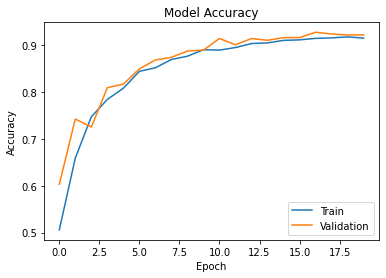

In [49]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

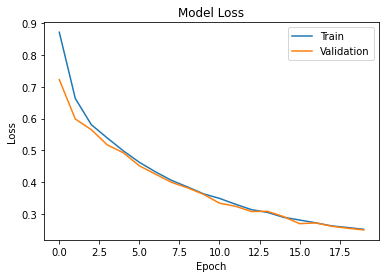

In [50]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Data Processing Q3
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed.

In [16]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True, 
                                    vertical_flip=True,
                                    rotation_range=90,
                                    width_shift_range=0.1,
                                    height_shift_range=0.2,
                                    zoom_range=0.1,
                                    )


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


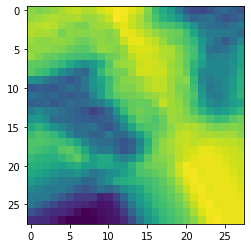

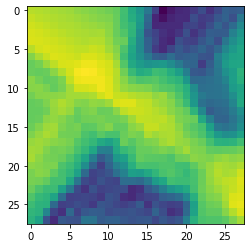

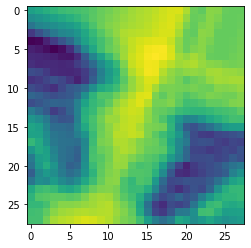

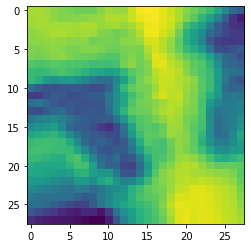

In [17]:
# We pick one image to "augment"
x = preprocessing.image.img_to_array(train_x[10])

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in data_generator.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(preprocessing.image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [18]:
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition Q3
In this section we will define the neural network arcitecture.

A deep network of your own design, incorporating design techniques and regularisation methods
you have learned about. You should use data augmentation. Try to achieve a good performance on
the test data

In [19]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=64, kernel_size=2, activation="relu",padding="same")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=128, kernel_size=2, activation="relu",padding="same")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Defines the second convolutional layer with max pooling.
conv_3 = layers.Conv2D(filters=256, kernel_size=2, activation="relu",padding="same")(pool_2)
pool_3 = layers.MaxPool2D(pool_size=(2, 2))(conv_3)

# Defines the second convolutional layer with max pooling.
dropout2 = layers.Dropout(0.2)(pool_3)
conv_4 = layers.Conv2D(filters=128, kernel_size=2, activation="relu",padding="same")(dropout2)
pool_4 = layers.MaxPool2D(pool_size=(2, 2))(conv_4)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
# drop = layers.Dropout(0.2)(pool_4)
flatten = layers.Flatten()(pool_3)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
# output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(flatten)
dense1 = layers.Dense(64, activation='relu')(flatten)
dropout1 = layers.Dropout(0.2)(dense1)
dense2 = layers.Dense(32, activation='relu')(dropout1)
dropout3 = layers.Dropout(0.2)(dense2)
output = layers.Dense(units=len(np.unique(train_y)), activation="sigmoid")(dropout3)
# output = layers.Dense(units=1, activation="sigmoid")(dense1)

# Initilises the defined model and prints summary of the model.
modelCustom = Model(inputs=input, outputs=output, name="Model")
modelCustom.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       32896     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 256)         131328

## Model Training Q3
This is where we define the training options and then train the model.


In [20]:
# Defines the parameters used during training.
BATCH_SIZE = 40
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

In [21]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
modelCustom.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])

In [22]:
# We use the data generator to pass the training and validation data to the model to train it.
history = modelCustom.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE), 
                    # steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/15
118/118 [==============================] - 17s 117ms/step - loss: 0.6971 - accuracy: 0.4420 - val_loss: 0.6878 - val_accuracy: 0.7271
Epoch 2/15
118/118 [==============================] - 13s 114ms/step - loss: 0.6830 - accuracy: 0.7099 - val_loss: 0.6766 - val_accuracy: 0.7424
Epoch 3/15
118/118 [==============================] - 13s 113ms/step - loss: 0.6732 - accuracy: 0.7396 - val_loss: 0.6678 - val_accuracy: 0.7424
Epoch 4/15
118/118 [==============================] - 13s 113ms/step - loss: 0.6652 - accuracy: 0.7415 - val_loss: 0.6591 - val_accuracy: 0.7424
Epoch 5/15
118/118 [==============================] - 14s 122ms/step - loss: 0.6576 - accuracy: 0.7424 - val_loss: 0.6523 - val_accuracy: 0.7424
Epoch 6/15
118/118 [==============================] - 13s 113ms/step - loss: 0.6504 - accuracy: 0.7421 - val_loss: 0.6456 - val_accuracy: 0.7424
Epoch 7/15
118/118 [==============================] - 13s 113ms/step - loss: 0.6427 - accuracy: 0.7421 - val_loss: 0.6385 - val_ac

In [85]:
modelCustom.evaluate(test_x, test_y)

20/20 [==============================] - 1s 33ms/step - loss: 0.3879 - accuracy: 0.8478


[0.38789114356040955, 0.8477563858032227]

In [91]:
modelCustom.evaluate(test_x, test_y)

20/20 [==============================] - 1s 29ms/step - loss: 0.5630 - accuracy: 0.6506


[0.5630245804786682, 0.6506410241127014]

In [50]:
test_x = test_x[...,np.newaxis]

## Plot Learning Curves Q3
This is where we visualise the training of the model.

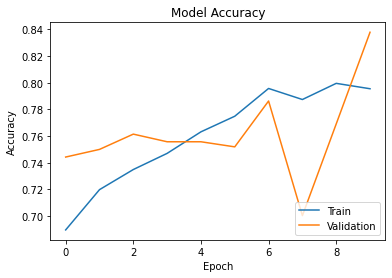

In [86]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

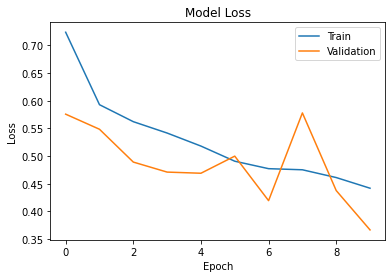

In [87]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Comparing All 3 Models for Multiclass Classification



###The Conclusion, Graph and data comparison is in attached word file. 

